# **人工智能实验结课项目**|基于K-means聚类的图片压缩方法

## 项目简介

本项目为“人工智能实验”课程的结课项目，旨在基于聚类算法实现图像压缩与色彩量化。主要工作包括：

1. **K-means 聚类量化**  
   对图像像素进行聚类处理，将原始的全彩像素空间压缩到 K 个代表颜色（质心），通过用簇中心颜色替换原始像素，实现图像大小的大幅度减少。  
2. **FCM（模糊 C-均值）精修**  
   在 K-means 聚类的基础上，引入 FCM 算法对聚类中心进行“模糊”调整，使代表颜色更平滑、更贴近视觉感知，提升压缩后图像的色彩保真度。  
3. **抖动（Dithering）优化**  
   可选地开启抖动处理，通过误差扩散算法将颜色量化误差在像素间扩散，降低色带现象，改善视觉效果。  
4. **实验设计与对比**  
   - 设定不同的 K 值（如 2、4、8、16）和抖动开关，分别生成压缩后图像。  
   - 对比展示原图与压缩图，评估压缩率、色彩重构误差等指标。  
5. **实现细节**  
   - 使用 Python 及常用库（NumPy、Pillow、Matplotlib）完成数据加载、聚类运算与可视化。  
   - 核心函数包括：`find_closest_centroids`、`compute_centroids`、`run_kmeans`、`run_fcm` 以及抖动算法 `dither`。  

通过本项目，可以直观体会聚类算法在图像量化中的应用，并比较 K-means 与 FCM、抖动策略对压缩效果与视觉质量的影响。  


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from fcm_core import run_fcm
from PIL import Image
import os

%matplotlib inline

### Atuo部分：用肘部法确定最佳K值

### 核心思想
肘部法(Elbow Method)通过分析不同K值下K-means聚类结果的失真度变化趋势来确定最佳聚类数。其核心观察点是：当K增加到真实聚类数时，失真度的下降会出现明显转折（形如手肘的拐点），该点之前梯度下降明显，之后变得平缓。

### 关键实现步骤

1.失真度计算

对每个候选K值（从min_k到max_k）运行K-means聚类

使用多次随机初始化（n_init）避免局部最优

记录每个K对应的最小失真度（所有初始化中的最优值）

2.强制单调递减处理

由于K-means的随机性，可能出现K增大但失真度反常增加的情况

采用线性插值修正：

对每个失真度值，若大于前一个值，则替换为前一个值（保守修正）

或使用前后点的线性插值（平滑修正）

保证失真度序列严格单调递减

3.曲率计算

使用中心差分法计算一阶和二阶导数：

一阶导数：dy/dx ≈ (y[i+1]-y[i-1])/(x[i+1]-x[i-1])

二阶导数：d²y/dx² ≈ (y[i+1]-2y[i]+y[i-1])/(Δx)²

曲率公式：

κ = |d²y/dx²| / (1+(dy/dx)²)^(3/2)
排除边界点以提高稳定性

4.最佳K值确定

找到曲率最大的点作为肘点

该点对应的K值即为最佳聚类数

In [20]:

def find_optimal_k(X, min_k=20, max_k=40, max_iters=5, round=1):
    """
    通过肘部法确定最佳K值，从min_k开始测试以提高效率
    
    参数:
        X (ndarray): 输入数据
        min_k (int): 最小测试的K值，默认为20
        max_k (int): 最大测试的K值，默认为40
        max_iters (int): K-Means的最大迭代次数，默认为10
    
    返回:
        optimal_k (int): 确定的最佳K值
    """
    distortions = []
    K_range = np.arange(min_k, max_k + 1)
    
    for k in K_range:
        print(f"计算K={k}时的失真...")
        min_distortion = float('inf')
        
        # 对每个K值进行多次随机初始化
        for _ in range(round):
            # 初始化质心
            initial_centroids = kMeans_init_centroids(X, k)
            # 运行K-Means
            centroids, idx = run_kMeans(X, initial_centroids, max_iters, plot_progress=False)
            # 计算当前初始化的失真
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
            min_distances = np.min(distances, axis=1)
            current_distortion = np.sum(min_distances**2) / X.shape[0]
            
            # 保留最小失真
            if current_distortion < min_distortion:
                min_distortion = current_distortion
        
        distortions.append(min_distortion)
    
    for i in range(1, len(distortions)):
        if distortions[i] > distortions[i-1]:
            print(f"警告：K={K_range[i]}时失真增加，建议检查初始化或增加迭代次数")
        
    distortions = np.array(enforce_monotonic_decrease(distortions, K_range))
            
    
    # 绘制肘部图
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, distortions, 'bx-')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Distortion')
    plt.title(f'Elbow Method (Testing K from {min_k} to {max_k})')
    plt.grid(True)
    plt.show()
    
    
    # 对失真值做归一化（保持K的原始单位）
    distortions_normalized = (distortions - min(distortions)) / (max(distortions) - min(distortions))*2000
   
    optimal_k = find_knee_curvature(K_range, distortions_normalized)
    return optimal_k

    '''deltas = np.diff(distortions)
    second_deltas = np.diff(1/deltas)
    optimal_k = K_range[np.argmax(np.abs(second_deltas)) + 1]  # +1因为二阶差分对应K+1
    
    print(f"根据肘部法，最佳K值为: {optimal_k}")
    return optimal_k'''

    '''def sigmoid_decay(k, a, b, c, d):
        """
        a * sigmoid(-b*(k - c)) + d
        其中：
        - a: 幅度缩放
        - b: 衰减速率（控制肘部陡峭度）
        - c: 肘点位置（关键参数！）
        - d: 基线失真
        """
        return a / (1 + np.exp(b*(k - c))) + d
    
    # 对失真值做归一化（保持K的原始单位）
    distortions_normalized = (distortions - min(distortions)) / (max(distortions) - min(distortions))

    # 对K值做缩放（适用于大K范围）
    k_scaled = K_range / max(K_range)

    # 重新拟合（注意调整初始猜测）
    popt, _ = curve_fit(sigmoid_decay, k_scaled, distortions_normalized)
    #popt, _ = curve_fit(sigmoid_decay, K_range, distortions, maxfev=5000)
        
    # 计算曲率
    k_smooth = np.linspace(min_k/max_k, 1, 100)
    d1 = -popt[0] / (k_smooth + popt[1])**2    
    d2 = 2*popt[0] / (k_smooth + popt[1])**3
    curvature = np.abs(d2) / (1 + d1**2)**1.5
    optimal_k = int(np.round(k_smooth[np.argmax(curvature)]))
    
    plt.figure(figsize=(10,6))
    plt.plot(k_scaled, distortions_normalized, 'bo')
    plt.plot(k_smooth, sigmoid_decay(k_smooth, *popt), 'r-')
    plt.axvline(optimal_k, color='k', linestyle='--')
    plt.xlabel('K'); plt.ylabel('Distortion'); 
    plt.legend()
    plt.show()
    # 确保optimal_k在合理范围内
    optimal_k = max(min_k, min(optimal_k, max_k))
    
    print(f"根据肘部法，最佳K值为: {optimal_k}")
    return optimal_k '''

In [21]:
import numpy as np

def enforce_monotonic_decrease(distortions, K_range):
    """
    智能强制单调递减处理：
    1. 识别连续递增区间
    2. 对整个区间进行线性插值修正
    返回修正后的序列和修改记录
    """
    corrected = np.array(distortions, dtype=float).copy()
    modified_segments = []
    i = 1
    n = len(corrected)
    
    while i < n:
        if corrected[i] > corrected[i-1]:
            # 找到递增区间的起始和结束
            start_idx = i-1
            while i < n and corrected[i] > corrected[i-1]:
                i += 1
            end_idx = min(i, n-1)
            
            # 记录修改区间
            original_values = corrected[start_idx:end_idx+1].copy()
            
            # 线性插值修正
            if end_idx < n-1:  # 如果不是最后一点
                corrected[start_idx+1:end_idx+1] = np.linspace(
                    corrected[start_idx], corrected[end_idx+1], 
                    end_idx - start_idx + 1
                )[1:]
            else:  # 如果是最后一段
                corrected[start_idx+1:end_idx+1] = corrected[start_idx]
            
            modified_segments.append((
                K_range[start_idx], K_range[end_idx],
                original_values, 
                corrected[start_idx:end_idx+1]
            ))
        else:
            i += 1
    
    # 打印修正报告
    if modified_segments:
        print("\n=== 失真修正报告 ===")
        for seg in modified_segments:
            start_k, end_k, orig, new = seg
            print(f"K={start_k}-{end_k}:")
            print(f"  原值: {np.round(orig, 2)}")
            print(f"  修正后: {np.round(new, 2)}")
            print(f"  最大修正: {np.max(orig-new):.2f}")
    
    return corrected.tolist()

In [22]:
def compute_curvature(x, y):
        """正确处理列表/数组输入的曲率计算"""
        x = np.asarray(x, dtype=float)  # 确保转换为NumPy数组
        y = np.asarray(y, dtype=float)
        
        # 一阶导数计算
        dy = np.zeros_like(y)
        dy[1:-1] = (y[2:] - y[:-2]) / (x[2:] - x[:-2])  # 中心差分
        dy[0] = (y[1] - y[0]) / (x[1] - x[0])           # 前向差分
        dy[-1] = (y[-1] - y[-2]) / (x[-1] - x[-2])       # 后向差分
        print(dy)

        # 二阶导数计算
        d2y = np.zeros_like(y)
        d2y[1:-1] = (dy[2:] - dy[:-2]) / (x[2:] - x[:-2])  # 中心差分
        d2y[0] = (dy[1] - dy[0]) / (x[1] - x[0])           # 前向差分
        d2y[-1] = (dy[-1] - dy[-2]) / (x[-1] - x[-2])       # 后向差分
        print(d2y)

        # 曲率计算
        curvature = d2y/ (1 + dy**2)**1.5
        return curvature

def find_knee_curvature(K, D):
    curvature = compute_curvature(K, D)
    print(curvature)
    # 排除边界点（前10%和后10%）
    valid_range = range(int(0.1*len(K)), int(0.9*len(K)))
    return K[valid_range[np.argmax(curvature[valid_range])]]

### 质量预设：K值 & 抖动开关

In [23]:
QUALITY = {
    "low" : {"K": 16, "dither": False},
    "mid" : {"K": 32, "dither": False},
    "high": {"K": 64, "dither": True}   # ← 仅 high 档启用抖动
}



### 计算每个样本所属的最近质心
    
    参数:
        X (ndarray): 输入数据，形状为 (m, n)      
        centroids (ndarray): 质心，形状为 (K, n)
    
    返回:
        idx (array_like): 每个样本最近的质心索引，形状为 (m,)

In [24]:
def find_closest_centroids(X, centroids):
    
    # 设置质心的数量 K
    K = centroids.shape[0]

    # 初始化返回的索引数组
    idx = np.zeros(X.shape[0], dtype=int)

    ### 在此开始编写代码 ###
       
    # 计算每个样本到所有质心的欧氏距离
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
            
    # 找到每个样本距离最近的质心的索引
    idx = np.argmin(distances, axis=1)
    
    return idx

### 通过计算分配给每个质心的数据点的均值，返回新的质心。
    
    参数:
        X (ndarray):   (m, n) 数据点矩阵，包含所有样本
        idx (ndarray): (m,) 一维数组，包含每个样本最近质心的索引。
                       具体来说，idx[i] 表示第 i 个样本最近的质心的索引
        K (int):       质心的数量
    
    返回:
        centroids (ndarray): (K, n) 新计算的质心矩阵

In [25]:
def compute_centroids(X, idx, K):
    """
    通过计算分配给每个质心的数据点的均值，返回新的质心。
    
    参数:
        X (ndarray):   (m, n) 数据点矩阵，包含所有样本
        idx (ndarray): (m,) 一维数组，包含每个样本最近质心的索引。
                       具体来说，idx[i] 表示第 i 个样本最近的质心的索引
        K (int):       质心的数量
    
    返回:
        centroids (ndarray): (K, n) 新计算的质心矩阵
    """
    
    # 有用的变量
    m, n = X.shape  # m 是样本数量，n 是特征数量
    
    # 初始化质心数组
    centroids = np.zeros((K, n))  # 质心矩阵，初始为全零
    
    ### 在此开始编写代码 ###
    for k in range(K):  # 遍历每个质心
        
        # 找到分配给第 k 个质心的所有数据点
        points = X[idx == k]
        
        # 计算这些点的均值作为新的质心位置
        if len(points) == 0:  # 空聚类处理
            #print(f"警告: 聚类 {k} 无数据点，随机重新初始化质心")
            centroids[k] = X[np.random.choice(m, 1), :]  # 随机选一个数据点作为新质心
        else:
            centroids[k] = np.mean(points, axis=0)  # 正常计算均值
        
    ### 在此结束编写代码 ###
    
    return centroids


### 在数据矩阵 X 上运行 K-Means 算法，其中 X 的每一行表示一个样本。

    参数:
        X (ndarray): (m, n) 数据矩阵，每一行是一个样本
        initial_centroids (ndarray): (K, n) 初始质心
        max_iters (int): 最大迭代次数，默认为 10
        plot_progress (bool): 是否可视化 K-Means 的执行过程，默认为 False

    返回:
        centroids (ndarray): (K, n) 最终的质心
        idx (ndarray): (m,) 每个样本所属的质心索引

In [26]:
def run_kMeans(X, initial_centroids, max_iters=10, plot_progress=False):
    
    # 初始化变量
    m, n = X.shape  # 样本数量和特征数量
    K = initial_centroids.shape[0]  # 质心的数量
    centroids = initial_centroids  # 当前质心，初始为给定的质心
    previous_centroids = centroids  # 上一次迭代的质心，用于可视化
    idx = np.zeros(m)  # 每个样本所属的质心索引，初始为全零
    plt.figure(figsize=(8, 6))  # 初始化图形大小

    # 执行 K-Means
    for i in range(max_iters):
        
        # 输出进度
        print("K-Means 迭代 %d/%d" % (i, max_iters-1))
        
        # 对于 X 中的每个样本，将其分配到最近的质心
        idx = find_closest_centroids(X, centroids)
        
        # 可视化当前的聚类进展
        if plot_progress:
            plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i)
            previous_centroids = centroids  # 更新之前的质心位置
            
        # 根据样本的分配情况，计算新的质心
        centroids = compute_centroids(X, idx, K)
    
    # 显示图像
    plt.show() 
    
    return centroids, idx  # 返回最终质心和样本分配结果


### 此函数用于初始化 K 个质心，用于在数据集 X 上执行 K-Means 算法。
    
    参数:
        X (ndarray): 数据点矩阵
        K (int):     质心/聚类的数量
    
    返回:
        centroids (ndarray): 初始化后的质心

In [27]:
def kMeans_init_centroids(X, K):
    
    # 随机重新排列样本的索引
    randidx = np.random.permutation(X.shape[0])
    
    # 选择前 K 个样本作为初始质心
    centroids = X[randidx[:K]]
    
    return centroids


### 上传一张彩色图片示例
让我们看看它原本长什么样

原始图像形状: (992, 880, 4)


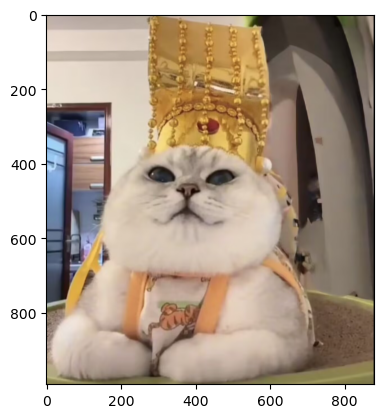

In [28]:
img = plt.imread('catking.png')
plt.imshow(img)
print("原始图像形状:", img.shape)

### 将图片进行预处理
全部转化为RGB图像并reshape为二维矩阵，形状为 (num_pixels, 3)，其中 num_pixels = rgb_img.shape[0] * rgb_img.shape[1]，3表示RGB三个通道

In [29]:
# 灰度图转为伪彩色图（R=G=B）
if img.ndim == 2:
    img = np.stack([img]*3, axis=-1)
# 处理 RGBA 图像（去掉 Alpha 通道）
elif img.shape[2] == 4:
    img = img[:, :, :3]
# 标准化到 0~255 范围内的浮点数，用于后续聚类
if img.dtype in (np.float32, np.float64):
    img = (img * 255.0).astype(np.float32)
else:
    img = img.astype(np.float32)
X   = img.reshape(-1, 3)
print("转换后的图像形状:", img.shape)  # 输出: (height, width, 3)

转换后的图像形状: (992, 880, 3)


In [30]:
choice = input("Choose quality [low / mid / high / auto] (default=mid): ").strip() or "mid"

if choice == "auto":
    # 使用肘部法自动确定最佳K值
    print("==> 正在使用肘部法自动确定最佳K值...")
    K = find_optimal_k(X, min_k=1, max_k=80)
    USE_DITHER = True if K > 32 else False  # 当K较大时启用抖动
    print(f"==> 自动选择: K={K}  dither={USE_DITHER}")
else:
    cfg = QUALITY.get(choice, QUALITY["mid"])
    K = cfg["K"]
    USE_DITHER = cfg["dither"]
    print(f"==> quality={choice}  K={K}  dither={USE_DITHER}")

==> quality=high  K=64  dither=True


In [31]:
# 将RGB图像重塑为二维矩阵，形状为 (num_pixels, 3)，
# 其中 num_pixels = rgb_img.shape[0] * rgb_img.shape[1]，3表示RGB三个通道
X_img = np.reshape(img, (img.shape[0] * img.shape[1], 3))

initial_centroids = kMeans_init_centroids(X, K)
km_centroids, km_labels = run_kMeans(
    X,
    initial_centroids,
    max_iters = 10,
    plot_progress = False
)

K-Means 迭代 0/9
K-Means 迭代 1/9
K-Means 迭代 2/9
K-Means 迭代 3/9
K-Means 迭代 4/9
K-Means 迭代 5/9
K-Means 迭代 6/9
K-Means 迭代 7/9
K-Means 迭代 8/9
K-Means 迭代 9/9


<Figure size 800x600 with 0 Axes>

In [32]:
# 打印km_labels的形状，km_labels是每个像素所属的聚类中心的索引
print("km_labels的形状:", km_labels.shape)

# 打印前五个元素的最近聚类中心的索引，km_labels中保存了每个像素的聚类标签（对应质心的索引）
print("前五个元素的最近质心索引:", km_labels[:5])

km_labels的形状: (872960,)
前五个元素的最近质心索引: [16 16 16 16 16]


### 绘制原始图像中发现的所有颜色。
如前所述，每个像素的颜色由RGB值表示，因此图表应该有3个轴——红色(R)、绿色(G)和蓝色(B)。你会注意到有很多点代表原始图像中的成千上万种颜色。红色标记代表运行K均值聚类后的质心。这些将是用来压缩图像的颜色。


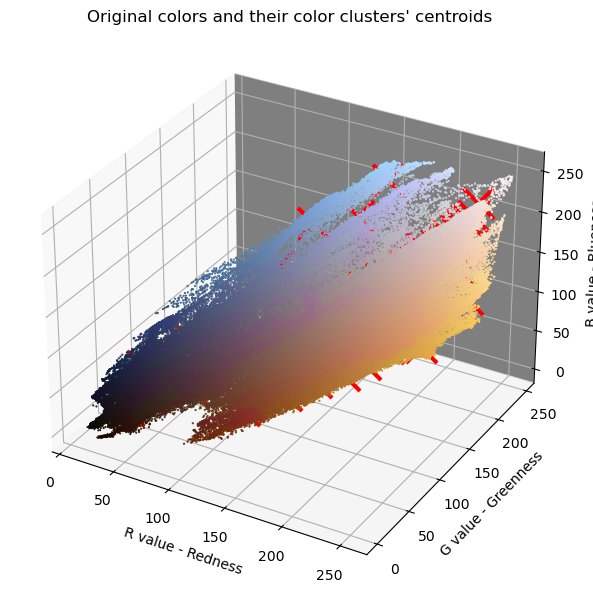

In [33]:
# 将像素数据缩放到 [0,1] 区间即可避免 RGBA 错误
plot_kMeans_RGB(X_img / 255.0, km_centroids / 255.0, km_labels, K)

让我们看看K-Means算法最终选择了哪几种最具代表性的颜色

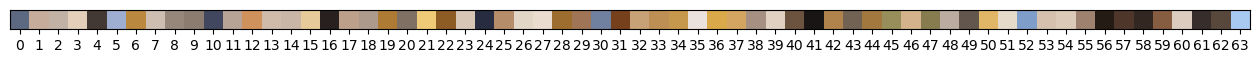

In [34]:
show_centroid_colors(km_centroids.astype(np.uint8))

在找到代表图像的代表颜色之后，现在可以使用 FCM 精修对 K-Means 聚类中心“模糊调整”，使代表颜色更真实、更平滑。同时硬量化，将每个像素最终归入最接近的颜色簇，实现压缩。

In [35]:
f_centroids, u = run_fcm(X, km_labels, m=2.0, max_iter=5, error=1e-2)

index_img = u.argmax(0).astype(np.uint8).reshape(img.shape[:2])

def dither(idx, K):
    h,w = idx.shape; out = idx.astype(np.int16)
    for y in range(h-1):
        for x in range(1,w-1):
            old, new = out[y,x], int(np.clip(round(out[y,x]),0,K-1))
            err = old-new; out[y,x]=new
            out[y,x+1]   += err*7/16
            out[y+1,x-1] += err*3/16
            out[y+1,x]   += err*5/16
            out[y+1,x+1] += err*1/16
    return np.clip(out,0,K-1).astype(np.uint8)

if USE_DITHER:
    index_img = dither(index_img, K)


### 把索引图 index_img 转回 RGB 以便显示
f_centroids 形状 (K,3)，index_img 形状 (H,W)
* 绘制原图 vs 压缩图
* 计算 PNG 大小

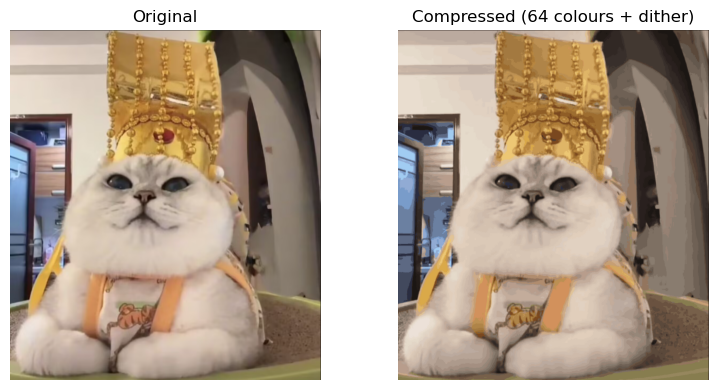

[质量评估]
原始文件大小: 991.1 KB
压缩文件大小: 117.9 KB (缩减率: 8.4x)
MSE均方误差: 29.08
PSNR峰值信噪比: 33.49 dB
使用颜色数: 64 (抖动启用)


In [36]:
import io
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, mean_squared_error as mse

compressed_rgb = f_centroids[index_img].astype(np.uint8)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img.astype(np.uint8))
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(compressed_rgb)
ax[1].set_title(f'Compressed ({K} colours{" + dither" if USE_DITHER else ""})')
ax[1].axis('off')
plt.tight_layout()
plt.show()

def calculate_distortion(original, compressed):
    """计算PSNR和MSE"""
    mse_value = mse(original, compressed)
    psnr_value = psnr(original, compressed, data_range=255)
    return mse_value, psnr_value

# 计算指标（注意转换为0-255范围）
original_uint8 = img.astype(np.uint8)
compressed_uint8 = compressed_rgb.astype(np.uint8)
mse_val, psnr_val = calculate_distortion(original_uint8, compressed_uint8)

orig_size = os.path.getsize("catking.png")
buf = io.BytesIO()
tmp_img = Image.fromarray(index_img, mode='P')
tmp_img.putpalette(
    f_centroids.clip(0,255).astype(np.uint8).flatten().tolist() + [0]*(768-K*3)
)
tmp_img.save(buf, format="PNG", optimize=True)
comp_size = buf.tell()
buf.close()

def human(n):
    for u in ['B','KB','MB','GB']:
        if n < 1024: return f"{n:.1f} {u}"
        n /= 1024

# ============== 打印结果（新增失真度输出） ==============
print(f"[质量评估]")
print(f"原始文件大小: {human(orig_size)}")
print(f"压缩文件大小: {human(comp_size)} (缩减率: {orig_size/comp_size:.1f}x)")
print(f"MSE均方误差: {mse_val:.2f}")
print(f"PSNR峰值信噪比: {psnr_val:.2f} dB")
print(f"使用颜色数: {K}{' (抖动启用)' if USE_DITHER else ''}")